## Task
Try to predict death rate from cirrhosis

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read data

data = pd.read_csv('data.csv', delimiter=';', index_col='Index')
data.head(5)

,Urban,Latebirths,Wine,Liquor,CirrhosisDeath
Index,,,,,
1,44,33.2,5,30,41.2
2,43,33.8,4,41,31.7
3,48,40.6,3,38,39.4
4,52,39.2,7,48,57.5
5,71,45.5,11,53,74.8


In [3]:
# split into train and test dataset

ratio = 0.67
n_train = int(len(data) * ratio)
n_test = len(data) - n_train
indexes = np.zeros(data.shape[0])
indexes[np.random.choice(len(data), n_train, replace=False)] = 1

X = np.array(data[indexes == 1].values)[:,:-1]
y = np.array(data[indexes == 1].values)[:,-1]
test_x = np.array(data[indexes == 0].values)[:,:-1]
test_y = np.array(data[indexes == 0].values)[:,-1]

In [4]:
# regularize data

means, stds = X.mean(axis=0), X.std(axis=0)
X = (X - means) / stds

In [5]:
X = np.hstack((np.ones((X.shape[0], 1)), X))
X[:5]

array([[ 1.        , -0.77921144, -1.04229367, -1.00697242, -1.50440518],
       [ 1.        , -0.84138256, -0.96232229, -1.14813677, -0.91056103],
       [ 1.        , -0.28184244, -0.24257986, -0.7246437 , -0.53266021],
       [ 1.        ,  0.89940895,  0.59711965, -0.15998627, -0.26273105],
       [ 1.        , -0.77921144, -0.46916544, -0.44231499,  0.38509893]])

In [6]:
def mserror(y, y_pred):
    # mean square error of prediction
    return sum((y-y_pred)**2)

In [7]:
def linear_prediction(X, w):
    # linear prediction for X with weights w
    return X.dot(w)

$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\}$$

In [8]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    # count gradient for current iteration
    prediction = linear_prediction(X[train_ind], w)
    answer = y[train_ind]
    difference = prediction - answer
    grads = []
    grad_0 =  difference
    grads.append(grad_0)
    for i in range(1, len(X[train_ind])):
        grad_i = X[train_ind][i] * difference
        grads.append(grad_i)
    return  w - 2 * eta / len(X) * np.array(grads)

In [9]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # use stochastic gradient descent in order to find the most exact weights
    weight_dist = np.inf # init difference between current and previous weights
    w = w_init # init weights with given value
    errors = [] # errors between predicted and real results in dataset
    iter_num = 0
    np.random.seed(seed)
        
    while weight_dist > min_weight_dist and iter_num < max_iter:
        random_ind = np.random.randint(X.shape[0])
        
        w_moved = stochastic_gradient_step(X, y, w, random_ind, eta) # weights moved by gradiend descent
        weight_dist = np.sqrt(np.sum((w_moved-w)**2)) 
        w = w_moved
        
        y_pred = linear_prediction(X, w)
        errors.append(mserror(y, y_pred)) # count error on dataset
        if verbose:
            print(w)
        iter_num += 1
        
    return w, errors

In [10]:
%%time
w_init = np.full(X.shape[1], 0)
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, w_init, max_iter=1e5, verbose=False)
print(stoch_grad_desc_weights)

[ 63.37941161  -4.02104386  11.5441326   14.06798893   1.53846716]
CPU times: user 3.34 s, sys: 15.2 ms, total: 3.35 s
Wall time: 3.34 s


Error by iter
Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

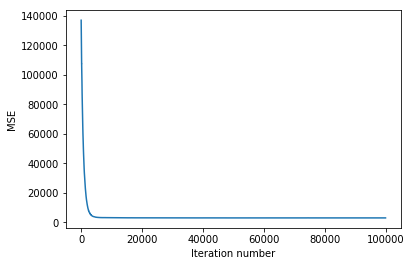

In [11]:
print ('Error by iter')
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

In [12]:
print ('Result error', stoch_errors_by_iter[-1])

Result error 3027.72025385


In [13]:
print ('Result weights')
stoch_grad_desc_weights

Result weights


array([ 63.37941161,  -4.02104386,  11.5441326 ,  14.06798893,   1.53846716])

In [14]:
# means, stds from training data
test_x = (test_x - means) / stds

In [15]:
test_x = np.hstack((np.ones((test_x.shape[0], 1)), test_x))

In [16]:
test_y_pred = test_x.dot(stoch_grad_desc_weights)

result = np.vstack((test_y.T, test_y_pred.T)).T
result

array([[  39.4       ,   45.07853498],
       [  56.6       ,   61.25516103],
       [  80.9       ,   66.60872266],
       [  70.3       ,   65.85526021],
       [  52.3       ,   39.12441167],
       [  86.9       ,   81.78434242],
       [  66.6       ,   56.52669136],
       [  98.1       ,   80.67039628],
       [  66.7       ,   70.20191348],
       [  48.        ,   59.13183046],
       [ 122.5       ,  120.77468903],
       [  33.8       ,   45.76510629],
       [  28.        ,   49.60628545],
       [  51.6       ,   37.42523833],
       [  55.7       ,   49.42397942],
       [  55.5       ,   68.93938063]])

## Sklearn
Compare with sklearn

In [17]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
sklearn_test_y = regr.predict(test_x)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test_y, sklearn_test_y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, sklearn_test_y))

Coefficients: 
 [  0.          -3.82647816  11.64845851  14.00562273   1.23084876]
Mean squared error: 124.00
Variance score: 0.78


In [19]:
compare = np.vstack((test_y.T, test_y_pred.T, sklearn_test_y.T)).T
compare

array([[  39.4       ,   45.07853498,   45.59372944],
       [  56.6       ,   61.25516103,   61.56588177],
       [  80.9       ,   66.60872266,   67.25326529],
       [  70.3       ,   65.85526021,   66.1415334 ],
       [  52.3       ,   39.12441167,   39.72427183],
       [  86.9       ,   81.78434242,   82.05457105],
       [  66.6       ,   56.52669136,   57.17446473],
       [  98.1       ,   80.67039628,   81.16351702],
       [  66.7       ,   70.20191348,   70.49875679],
       [  48.        ,   59.13183046,   59.33083776],
       [ 122.5       ,  120.77468903,  119.50769658],
       [  33.8       ,   45.76510629,   45.565598  ],
       [  28.        ,   49.60628545,   49.50230183],
       [  51.6       ,   37.42523833,   37.91799226],
       [  55.7       ,   49.42397942,   50.02530923],
       [  55.5       ,   68.93938063,   69.21646273]])